In [1]:
from info_nas.datasets.networks.pretrained import pretrain_network_cifar
from info_nas.datasets.networks.utils import load_nasbench
from nasbench_pytorch.datasets.cifar10 import prepare_dataset

In [2]:
seed = 42
batch_size = 32
num_workers = 2

dataset = prepare_dataset(batch_size, root='../data/cifar/', validation_size=1000, random_state=seed,
                          num_workers=num_workers)
train, n_train, val, n_val, test, n_test = dataset


--- Preparing CIFAR10 Data ---
Files already downloaded and verified
Files already downloaded and verified
--- CIFAR10 Data Prepared ---



In [3]:
import os

checkpoint_dir = '../data/train_checkpoints//'

os.listdir(f'{checkpoint_dir}')

['023bfb8418a28942ee4a9734e373ca67.tar',
 '083a8045a46ac2a25a34c8fab47f6ecb.tar',
 '23b8304199794a8eb423def3bd0c343d.tar',
 '663737f875418ec3838f2c9eadca7b50.tar']

In [4]:
from nasbench import api

nasbench_path = '../data/nasbench_only108.tfrecord'
nb = api.NASBench(nasbench_path)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 32 seconds


In [28]:
import torch
from info_nas.datasets.networks.utils import load_trained_net

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net_path = f'{checkpoint_dir}083a8045a46ac2a25a34c8fab47f6ecb.tar'
net_hash, net, info = load_trained_net(net_path, nb, device=device)
net

Network(
  (layers): ModuleList(
    (0): ConvBnRelu(
      (conv_bn_relu): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): Cell(
      (vertex_op): ModuleList(
        (0): None
        (1): MaxPool3x3(
          (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        )
        (2): Conv3x3BnRelu(
          (conv3x3): ConvBnRelu(
            (conv_bn_relu): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
        )
        (3): MaxPool3x3(
          (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        )
        

In [29]:
info

{'train_loss': tensor(0.2445, device='cuda:0'),
 'train_accuracy': tensor(0.9148, device='cuda:0'),
 'val_loss': tensor(0.3229, device='cuda:0'),
 'val_accuracy': tensor(0.8910, device='cuda:0'),
 'test_loss': tensor(0.3741, device='cuda:0'),
 'test_accuracy': tensor(0.8813, device='cuda:0')}

In [31]:
net.classifier.bias

Parameter containing:
tensor([ 0.2086, -0.3433,  0.1516,  0.3202,  0.1540, -0.0996, -0.0075,  0.0369,
        -0.1386, -0.2822], device='cuda:0', requires_grad=True)

- heatmaps todo
  - all net weights for e.g. airplane
  - minmaxscale to (-1,1), compare net
    - bias?
  - standardscale instead of normalize
  - predict one image, sort values by weights
    - how to normalize??

<IPython.core.display.Javascript object>


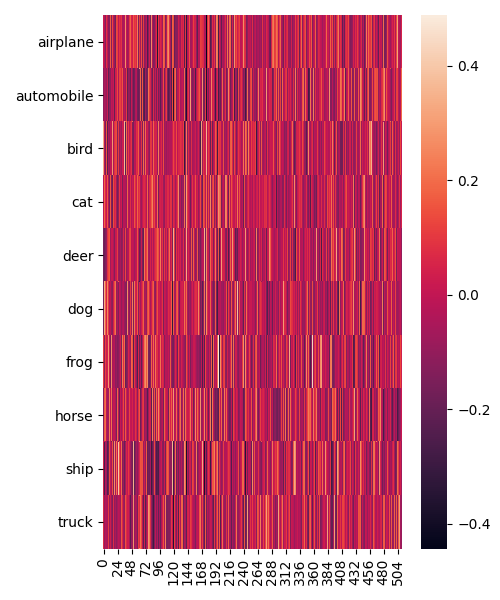

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

labels = "airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck".split(', ')

weights = net.classifier.weight.detach().cpu()

plt.figure(figsize=(5,6))
sns.heatmap(weights, yticklabels=labels)
#plt.imshow(net.classifier.weight.detach().cpu())
plt.tight_layout()
plt.savefig('cifar_weights.png')
plt.show()

In [8]:
import numpy as np

print(net_hash)
np.array([net_hash, net_hash, net_hash])

023bfb8418a28942ee4a9734e373ca67


array(['023bfb8418a28942ee4a9734e373ca67',
       '023bfb8418a28942ee4a9734e373ca67',
       '023bfb8418a28942ee4a9734e373ca67'], dtype='<U32')

In [9]:
type(net_hash)

str

In [36]:
for batch_idx, (inputs, targets) in enumerate(val):
    inputs, targets = inputs.to(device), targets.to(device)
    break
    
print(inputs.shape)
print(targets.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [33]:
nasbench = load_nasbench(nasbench_path)

Loading dataset from file... This may take a few minutes...
Loaded dataset in 33 seconds


In [34]:
from nasbench_pytorch.model import Network as NBNetwork

net = nasbench[0]
net = NBNetwork((net[2], net[1]), 10)
net = net.to(device)

In [16]:
with torch.no_grad():
    outputs = net(inputs.to(device))
    
outputs.shape

torch.Size([32, 10])

In [17]:
with torch.no_grad():
    out_list = net.get_cell_outputs(inputs, return_inputs=False)
    
[print(o.shape) for o in out_list]
print()

torch.Size([32, 128, 32, 32])
torch.Size([32, 128, 32, 32])
torch.Size([32, 128, 32, 32])
torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 16, 16])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512])
torch.Size([32, 10])



In [18]:
with torch.no_grad():
    in_list, out_list = net.get_cell_outputs(inputs, return_inputs=True)
    
[print(i.shape, ' -> ', o.shape) for i, o in zip(in_list, out_list)]
print()

torch.Size([32, 128, 32, 32])  ->  torch.Size([32, 128, 32, 32])
torch.Size([32, 128, 32, 32])  ->  torch.Size([32, 128, 32, 32])
torch.Size([32, 128, 32, 32])  ->  torch.Size([32, 128, 32, 32])
torch.Size([32, 128, 16, 16])  ->  torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 16, 16])  ->  torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 16, 16])  ->  torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 8, 8])  ->  torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])  ->  torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])  ->  torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])  ->  torch.Size([32, 512])
torch.Size([32, 512])  ->  torch.Size([32, 10])



In [ ]:
torch.cat(in_list[:2]).shape

In [37]:
with torch.no_grad():
    in_list, out_list = net.get_cell_outputs(inputs, return_inputs=True)
    
for in_image in in_list[-2][0][:10]:
    print(in_image.shape)

torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])


In [64]:
means = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
stds = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
im = inputs[1].detach().cpu() * stds + means

In [65]:
targets[1]

tensor(9, device='cuda:0')

<IPython.core.display.Javascript object>


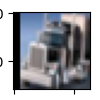

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [67]:
plt.figure(figsize=(1,1))
plt.imshow(im.moveaxis(0,2))
plt.show()

<IPython.core.display.Javascript object>


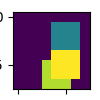

<IPython.core.display.Javascript object>


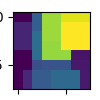

<IPython.core.display.Javascript object>


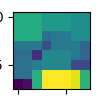

<IPython.core.display.Javascript object>


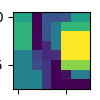

<IPython.core.display.Javascript object>


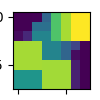

<IPython.core.display.Javascript object>


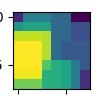

<IPython.core.display.Javascript object>


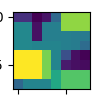

<IPython.core.display.Javascript object>


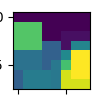

<IPython.core.display.Javascript object>


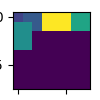

<IPython.core.display.Javascript object>


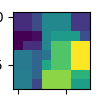

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

for in_image in in_list[-2][1][:10]:
    plt.figure(figsize=(1,1))
    plt.imshow(in_image.detach().cpu())
    plt.show()


In [ ]:
# Check if all shapes the same

In [44]:
for i, next_net in enumerate(nasbench[:150]):
    if (i % 5) == 0:
        print(i)

    next_net = NBNetwork((next_net[2], next_net[1]), 10)
    
    with torch.no_grad():        
        n_in, n_out = next_net.get_cell_outputs(inputs, return_inputs=True)
        
        for i, ni in zip(in_list, n_in):
            assert i.shape == ni.shape
            
        for o, no in zip(out_list, n_out):
            assert o.shape == no.shape

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145


In [43]:
len(nasbench)

423624